In [1]:
#VAE to generate images from a noise distribution with TF
# http://kvfrans.com/variational-autoencoders-explained/

from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Import MNIST data

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Tensorflow Examples Models/mnist', one_hot=True)

from keras import backend as K
#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting ../Tensorflow Examples Models/mnist\train-images-idx3-ubyte.gz
Extracting ../Tensorflow Examples Models/mnist\train-labels-idx1-ubyte.gz
Extracting ../Tensorflow Examples Models/mnist\t10k-images-idx3-ubyte.gz
Extracting ../Tensorflow Examples Models/mnist\t10k-labels-idx1-ubyte.gz


Using TensorFlow backend.


In [2]:
#Params
learning_rate = 0.001
num_steps = 30000
batch_size = 64

#Network Params
image_dim = 784 #MNIST images are 28*28 pixels
hidden_dim = 512
latent_dim = 2

#A custom initialization(see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1.0/tf.sqrt(shape[0]/2.0))

In [3]:
#Define weights and biases
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}

biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [4]:
#Building the encoder
x = tf.placeholder(dtype=tf.float32, shape=[None, image_dim])

encoder = tf.matmul(x, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']

#Sampler: Normal (Gaussian) random distribution
eps = tf.random_normal(shape=tf.shape(z_std), 
                       dtype=tf.float32, 
                       mean=0., 
                       stddev=1.0, 
                       name='epsilon')
z = z_mean + tf.exp(z_std/2) * eps

#Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

In [5]:
#Define VAE loss
def vae_loss(x_reconstructed, x_true):
    #Reconstruction loss
    encode_decode_loss = x_true*tf.log(1e-10 + x_reconstructed) + (1-x_true)*tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    #KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, x)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

#Init global variables
init = tf.global_variables_initializer()

In [6]:
training_loss = []
#Start training
#Start a new TF Sesssion
sess = tf.Session()

#Run the initializer
sess.run(init)

#Training
for i in range(1, num_steps+1):
    #Prepare data
    #Get the next batch of MNIST data(only need images, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    
    #Train
    feed_dict = {x: batch_x}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    training_loss.append(l)
    
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))

Step 1, Loss: 624.147888
Step 1000, Loss: 192.141052
Step 2000, Loss: 203.032898
Step 3000, Loss: 185.140579
Step 4000, Loss: 177.956314
Step 5000, Loss: 181.352142
Step 6000, Loss: 182.459473
Step 7000, Loss: 178.843964
Step 8000, Loss: 171.382126
Step 9000, Loss: 171.154358
Step 10000, Loss: 175.849060
Step 11000, Loss: 175.914078
Step 12000, Loss: 182.498993
Step 13000, Loss: 185.558456
Step 14000, Loss: 183.309296
Step 15000, Loss: 170.489822
Step 16000, Loss: 164.790680
Step 17000, Loss: 170.149811
Step 18000, Loss: 181.991089
Step 19000, Loss: 178.771301
Step 20000, Loss: 168.188690
Step 21000, Loss: 156.346802
Step 22000, Loss: 172.815567
Step 23000, Loss: 174.291321
Step 24000, Loss: 174.004776
Step 25000, Loss: 174.212341
Step 26000, Loss: 168.378433
Step 27000, Loss: 172.364899
Step 28000, Loss: 172.713181
Step 29000, Loss: 158.763092
Step 30000, Loss: 172.471436


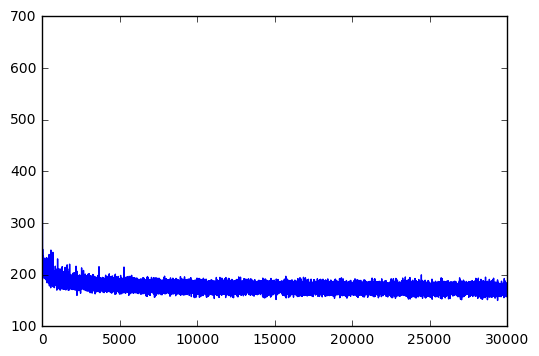

In [7]:
plt.plot(training_loss)
plt.show()

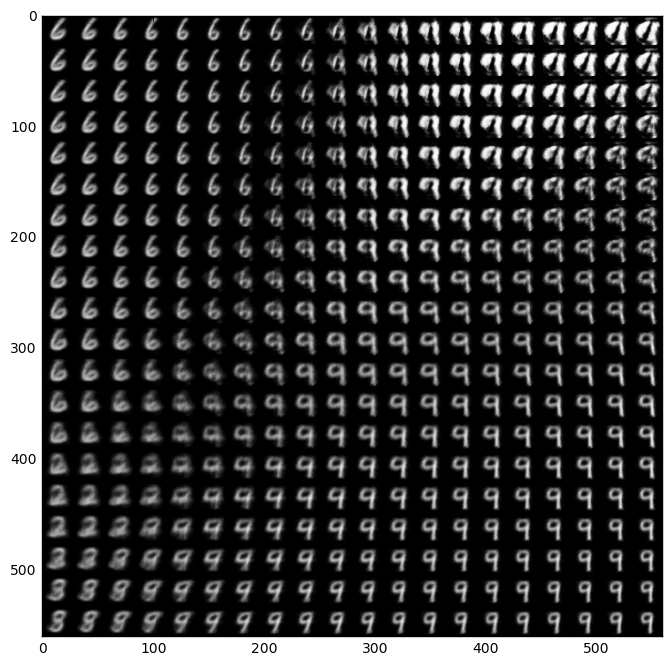

In [9]:
#Testing
#Generator takes noise as input
noise_input = tf.placeholder(dtype=tf.float32, shape=[None, latent_dim])

#Rebuild the decoder to create image from noise
decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

#Building a manifold of generated digits
n = 20
x_axis = np.linspace(-3, 3, n)
y_axis = np.linspace(-3, 3, n)

canvas = np.empty((28*n, 28*n))

for i, yi in enumerate(x_axis):
    for j, xi in enumerate(y_axis):
        z_mu = np.array([[xi, yi]] * batch_size)
        x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
        canvas[(n-i-1)*28: (n-i)*28, j*28: (j+1)*28] = x_mean[0].reshape(28,28)
        
plt.figure(figsize=(8,10))
xi, yi = np.meshgrid(x_axis, y_axis)
plt.imshow(canvas, origin='upper', cmap='gray')
plt.show()